## Example 3 - Direct and Indirect Pathways 

Here we investigate the effect of ENSO on the Southern Hemisphere mid-latitude jet (Jet) in early summer months (OND). ENSO is hypothesised to affects the Jet directly, via a tropospheric pathway, and indirectly via the break down of the Stratopsheric Polar Vortex (SPV), also called the stratospheric pathway. We quantify both pathways and compare their relative importance.


<img src="../images/ex3.png" width="500" height="600">

### References / Notes

1. The calculation of the SPV is described here: https://journals.ametsoc.org/jas/article/64/8/2968/103627/Interannual-Variability-in-the-Southern-Hemisphere
2. Details on the tropospheric and stratospheric pathway of ENSO on Jet are for example discussed here: https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JD030173

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal

### Step 1) Load the data + plot time-series

In [2]:
# data from 1950 to 2019, year 2002 was removed because it is the only SH Sudden Stratospheric Warming on record.
enso   = iris.load_cube('../sample_data/enso_full_ond_no2002.nc')
jet    = iris.load_cube('../sample_data/sh_jet_ond_no2002.nc')  
spv = iris.load_cube('../sample_data/vortex_breakdown_no2002.nc') #'breakdown date in days after 1st Oct' )

#### Plot the data

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


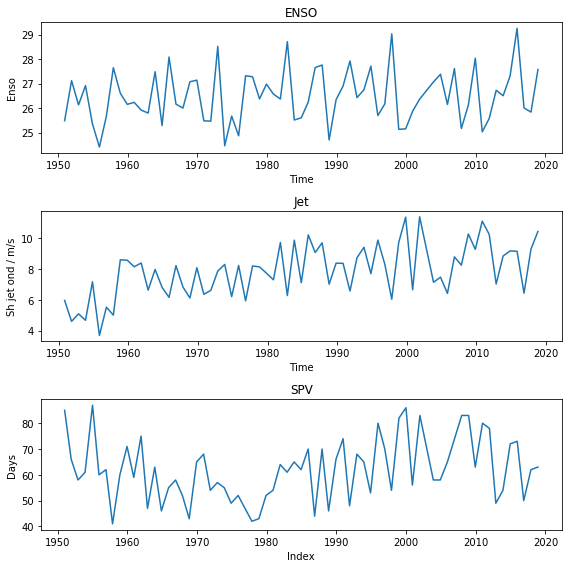

In [3]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(311)
qplt.plot(enso)
plt.title('ENSO')

plt.subplot(312)
qplt.plot(jet)
plt.title('Jet')

plt.subplot(313)
qplt.plot(spv)
plt.title('SPV')
plt.tight_layout()


### Step 2)   Data Processing

#### Standardize the data (zero mean, unit variance)

In [4]:
ENSO = (enso - np.mean(enso.data))/np.std(enso.data)
JET = (jet - np.mean(jet.data))/np.std(jet.data)
SPV = (spv - np.mean(spv.data))/np.std(spv.data)

#### Detrend

In [5]:
ENSO   = signal.detrend(ENSO.data)
JET    = signal.detrend(JET.data)
SPV = signal.detrend(SPV.data)

### Step 3)   Data Analysis

In [6]:
#================================================================
# Determine the total effect of ENSO on Jet
#================================================================
X =  ENSO[:]
Y = JET[:]

model = sm.OLS(Y,X)
results = model.fit()

ENSOtoJET_tot = round(results.params[0],2)

print("The total causal effect of ENSO on JET  =",ENSOtoJET_tot)

The total causal effect of ENSO on JET  = -0.14


In [7]:
#==========================================================================
# Determine the tropospheric-only effect of ENSO on JET by conditioning on SPV
#==========================================================================
X = np.stack([ENSO, SPV]).T
Y = JET[:]

model = sm.OLS(Y,X)
results = model.fit()

ENSOtoJET_tropo = results.params[0]
VORTEXtoJET     = results.params[1] 

print("The direct effect of ENSO on Jet (conditioned on SPV) is ", round(ENSOtoJET_tropo,2))
print("The regression coeff. of SPV on Jet is ", round(VORTEXtoJET,2))

The direct effect of ENSO on Jet (conditioned on SPV) is  -0.04
The regression coeff. of SPV on Jet is  0.39


In [9]:
#==========================================================================
# Determine the stratoshperic pathway from ENSO --> JET
#==========================================================================

#============
# ENSO to SPV:
#============
X = ENSO[:]
Y = SPV[:]

model = sm.OLS(Y,X)
results = model.fit()

ENSOtoVORTEX = results.params[0]

#============
# SPV to Jet (same as above)
#============

X = np.stack([ENSO, SPV]).T
Y = JET[:]

model = sm.OLS(Y,X)
results = model.fit()

VORTEXtoJET     = results.params[1] 

#============
# Strength of stratopsheric pathway
#============
Strato_pathway = ENSOtoVORTEX * VORTEXtoJET 


print("The causal effect of ENSO on SPV is ", round(ENSOtoVORTEX,2))
print("The causal effect of SPV on Jet (cond on ENSO) is ", round(VORTEXtoJET ,2))
print("The strength of the stratospheric pathway is ", round(Strato_pathway,2))

The causal effect of ENSO on SPV is  -0.26
The causal effect of SPV on Jet (cond on ENSO) is  0.39
The strength of the stratospheric pathway is  -0.1


In [11]:
#==========================================================================
# Compare the total effect with the sum of the stratospheric and tropospheric patways
#==========================================================================

print("The total effect of ENSO on JET  =", ENSOtoJET_tot)

print("The sum of tropospheric + stratospheric pathways is ", round(Strato_pathway + ENSOtoJET_tropo,2))

The total effect of ENSO on JET  = -0.14
The sum of tropospheric + stratospheric pathways is  -0.14


### Conclusions

When regressing Jet on ENSO, a negative, total effect of - 0.14 is found. Separating the indirect stratospheric pathway (ENSO $\to$ VORTEX $\to$ JET) from the direct tropospheric pathway (ENSO$\to$JET), the direct effect of ENSO on JET is found to be weaker (-0.04) than the indirect, stratopsheric pathway (-0.10).
